In [ ]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy.special import expit as sigmoid

In [3]:
DATA_PATH = "/home/taheera.ahmed/data/nedbygging/"
data_path = Path(DATA_PATH)

CLASS_LABELS = {
    "unclassified": 0,  # Uklassifisert
    "settlement_transport": 1,  # Bebyggelse/samferdsel
    "cultivated_land": 2,  # Dyrket mark
    "grassland": 3,  # Grasmark
    "forest": 4,  # Skog
    "heath_and_open_vegetation": 5,  # Hei og åpen vegetasjon
    "sparse_vegetation_land": 6,  # Lite vegetert mark
    "wetland": 7,  # Våtmark
    "water": 8,  # Vann
}
CLASS_NAMES = {v: k for k, v in CLASS_LABELS.items()}
class_labels = CLASS_LABELS.keys()


def get_color_map_and_legend():
    # Define colors corresponding to each class in order
    class_colors = [
        "black",
        "red",
        "yellow",
        "lime",
        "green",
        "purple",
        "cyan",
        "magenta",
        "blue",
    ]
    # Create legend elements with the corresponding colors
    legend_elements = [
        Patch(facecolor=class_colors[i], edgecolor="black", label=label)
        for i, label in enumerate(CLASS_LABELS.keys())
    ]
    return class_colors, legend_elements


# Retrieve colors and legend elements
class_colors, legend_elements = get_color_map_and_legend()

In [4]:
train_path_imgs = data_path / "new_train_val_scene" / "train"
train_path_masks = data_path / "new_train_val_truth" / "train"
val_path_imgs = data_path / "new_train_val_scene" / "val"
val_path_masks = data_path / "new_train_val_truth" / "val"

In [5]:
train_imgs = list((train_path_imgs).glob("*.tif"))
train_masks = list((train_path_masks).glob("*.tif"))

val_imgs = list((val_path_imgs).glob("*.tif"))
val_masks = list((val_path_masks).glob("*.tif"))

In [6]:
train_imgs.sort()
train_masks.sort()

val_imgs.sort()
val_masks.sort()

## Choose one image


In [ ]:
idx = 0
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])
print(train_imgs[idx])
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

/home/taheera.ahmed/data/nedbygging/new_train_val_scene/train/scene_2019_1.tif
Image shape: (30, 5010, 5004)
Mask shape: (1, 5010, 5004)


In [8]:
month_idx = 1  # Change this based on the desired month (0-4)
band_offset = month_idx * 6  # Since each month has 6 bands

blue_band = band_offset + 0
green_band = band_offset + 1
red_band = band_offset + 2


In [9]:
rgb_img = img[[red_band, green_band, blue_band]].data

## just normalized


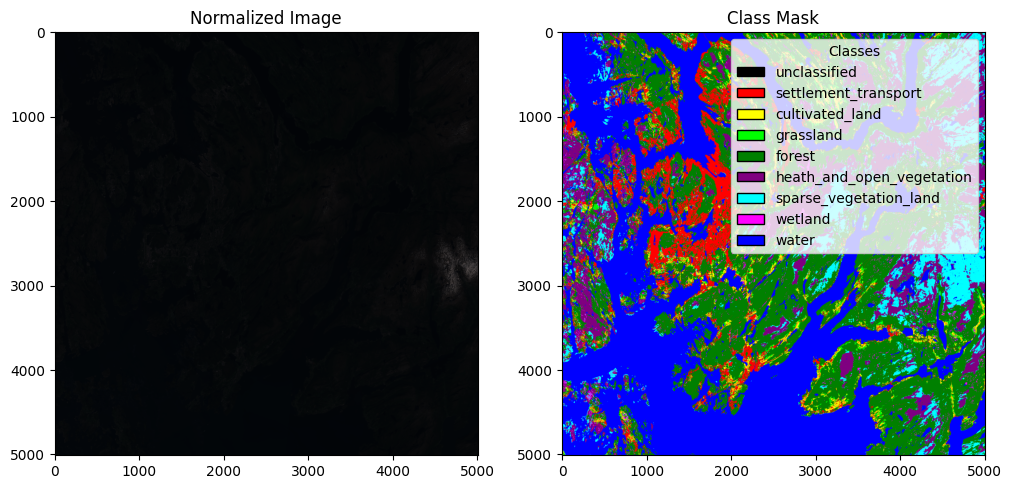

In [10]:
def normalize_image(image):
    """Normalize image using min-max scaling."""
    return (image - image.min()) / (image.max() - image.min())


norm_image = normalize_image(rgb_img)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Display the corrected image
axs[0].imshow(norm_image.transpose(1, 2, 0))
axs[0].set_title("Normalized Image")

# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")
plt.show()


## Precentile clipping


Okay this is better


The pixel values are extremely high (millions to hundreds of millions), which explains why the image appears too dark when divided by 2000 or even normalized to [0,1].


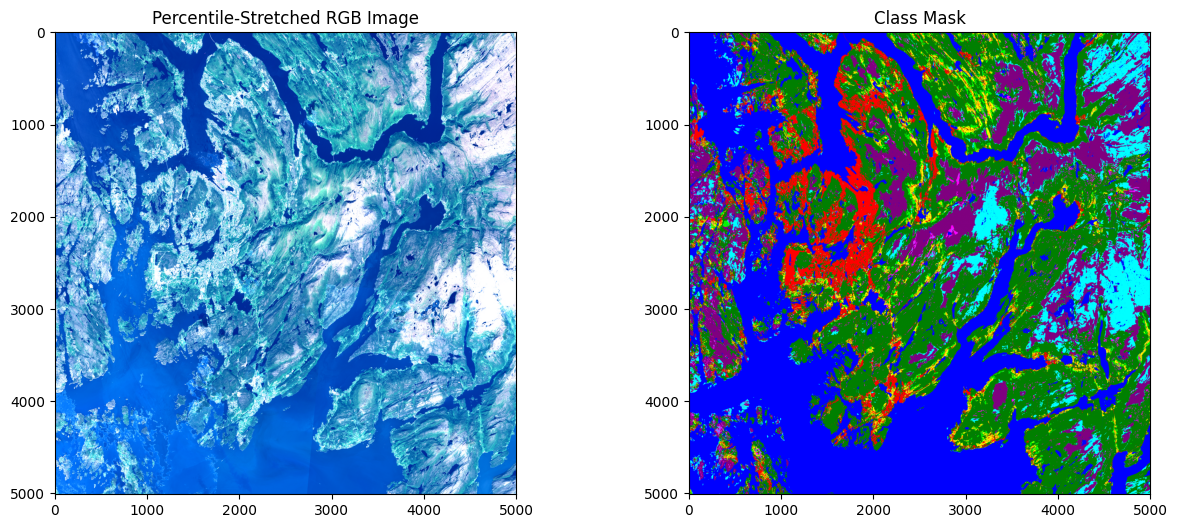

In [17]:
def normalize_percentile(img_array, percentiles=(10, 90)):
    """Normalize image using percentile clipping to enhance contrast."""
    min_val, max_val = np.percentile(img_array, percentiles)
    return np.clip((img_array - min_val) / (max_val - min_val), 0, 1)


_, axs = plt.subplots(1, 2, figsize=(15, 6))
rgb_img = img.data[[red_band, green_band, blue_band]].transpose((1, 2, 0))
rgb_norm_percentile = normalize_percentile(rgb_img)  # Apply normalization

# Display the corrected image
axs[0].imshow(rgb_norm_percentile)
axs[0].set_title("Percentile-Stretched RGB Image")

# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

# Create a legend for the mask
legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label)
    for color, label in zip(class_colors, class_labels, strict=False)
]

# axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")
plt.show()

## Histogram equalization


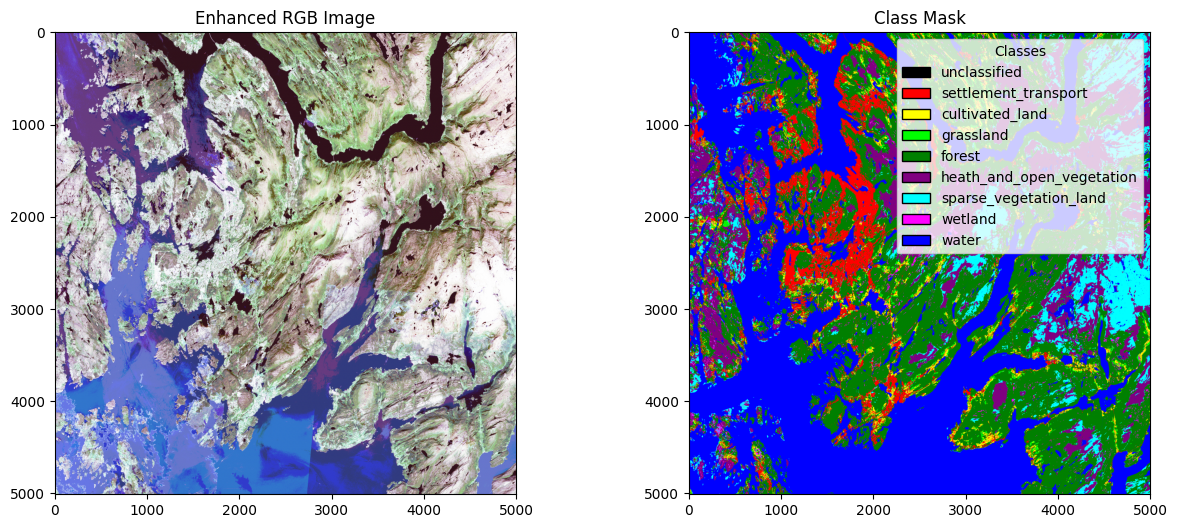

In [18]:
_, axs = plt.subplots(1, 2, figsize=(15, 6))


def hist_equalization(image):
    """Apply histogram equalization on an image."""
    image = (image * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
    for i in range(3):  # Apply to each channel separately
        image[..., i] = cv2.equalizeHist(image[..., i])
    return image / 255.0  # Scale back to [0,1]


# rgb_norm = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
rgb_norm_percentile = normalize_image(rgb_img)  # Apply normalization
rgb_hist = hist_equalization(rgb_norm_percentile)
axs[0].imshow(rgb_hist)
axs[0].set_title("Enhanced RGB Image")


# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

# Create a legend for the mask
legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label)
    for color, label in zip(class_colors, class_labels, strict=False)
]

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")

plt.show()


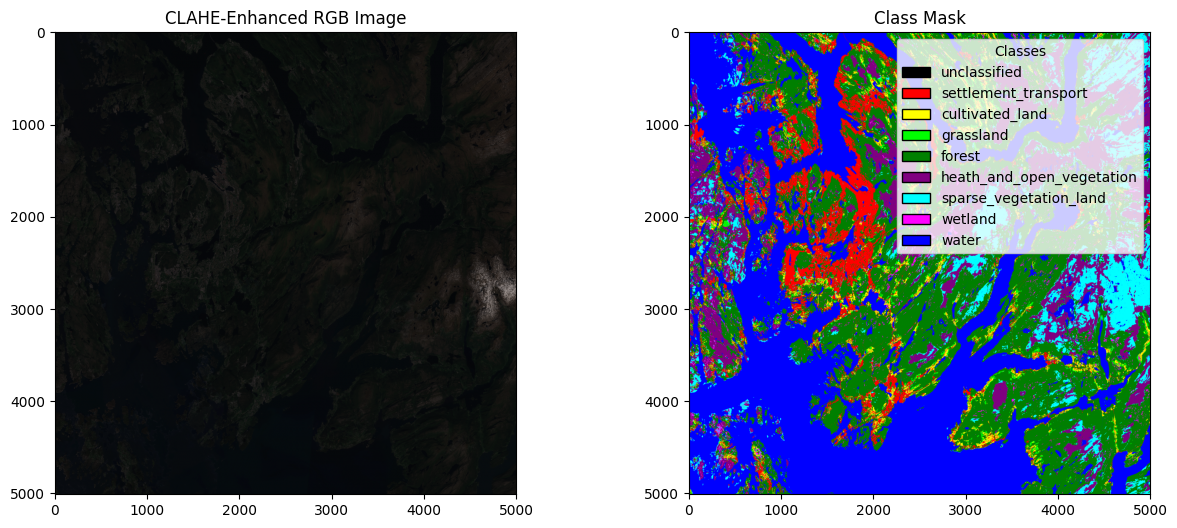

In [ ]:
def adaptive_histogram_equalization(image):
    """Apply adaptive histogram equalization on each channel separately."""
    image = (image * 255).astype(np.uint8)  # Convert to uint8
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    for i in range(3):  # Apply CLAHE per channel
        image[..., i] = clahe.apply(image[..., i])

    return image / 255.0  # Scale back to [0,1]


_, axs = plt.subplots(1, 2, figsize=(15, 6))
rgb_norm = normalize_image(rgb_img)  # Apply normalization
rgb_adapt = adaptive_histogram_equalization(rgb_norm)
axs[0].imshow(rgb_adapt)
axs[0].set_title("CLAHE-Enhanced RGB Image")

# Plot the mask
axs[1].imshow(mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

# Create a legend for the mask
legend_elements = [
    Patch(facecolor=color, edgecolor="black", label=label)
    for color, label in zip(class_colors, class_labels, strict=False)
]

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")

plt.show()


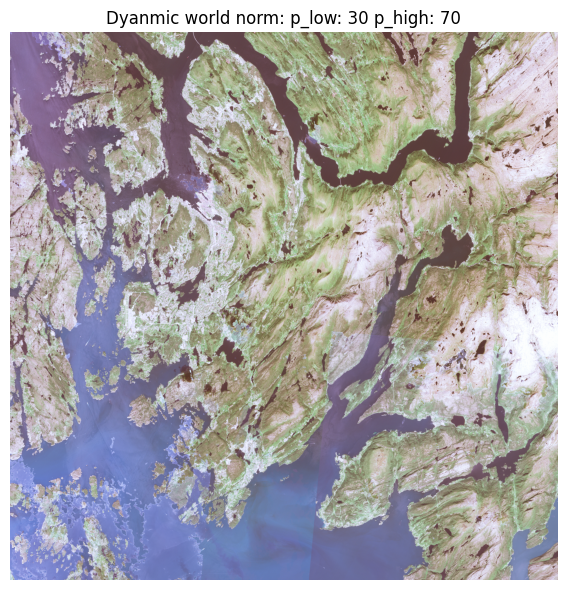

In [33]:
def dynamic_world_normalization(image, p_low=30, p_high=80, log_transform=True):
    """
    Apply the Dynamic World normalization scheme to an image.

    Parameters:
        image (np.ndarray): Input image array (H, W, C).
        p_low (int): Lower percentile for remapping.
        p_high (int): Upper percentile for remapping.
        log_transform (bool): Whether to apply log-transform.

    Returns:
        np.ndarray: Normalized image.
    """
    image = image.astype(np.float32)

    if log_transform:
        image = np.log1p(image)  # log(1 + x) to prevent log(0) issues

    norm_image = np.zeros_like(image)

    for c in range(image.shape[2]):  # Process each channel separately
        low, high = np.percentile(image[..., c], [p_low, p_high])
        if low == high:
            norm_image[..., c] = 0.5  # Assign a neutral value if no variance
        else:
            norm_image[..., c] = sigmoid((image[..., c] - low) / (high - low))

    return norm_image


# Example usage
p_low = 30
p_high = 70

# Create a subplot for each set
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

rgb_dynamic_world = dynamic_world_normalization(rgb_img, p_low, p_high)

# Plot the normalized image
ax.imshow(rgb_dynamic_world)
ax.set_title(f"Dyanmic world norm: p_low: {p_low} p_high: {p_high}")
ax.axis("off")

plt.tight_layout()
plt.show()

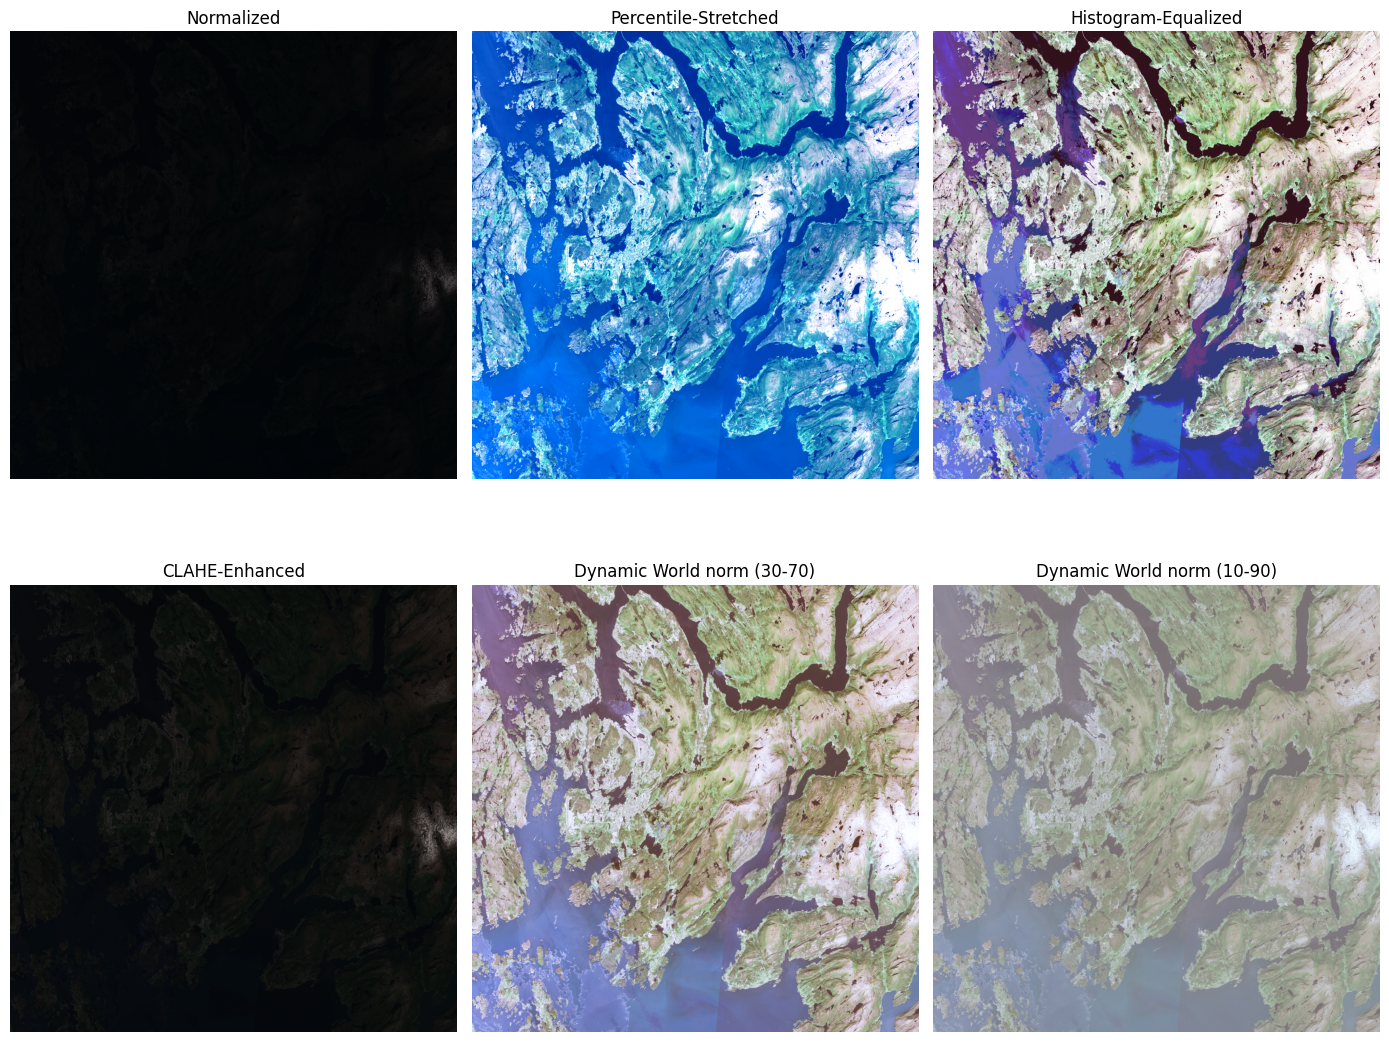

In [21]:
# plot all the different methods in one
_, axs = plt.subplots(2, 3, figsize=(14, 12))

# Original RGB image
axs[0, 0].imshow(normalize_image(rgb_img))
axs[0, 0].set_title("Normalized")
axs[0, 0].axis("off")

axs[0, 1].imshow(normalize_percentile(rgb_img))
axs[0, 1].set_title("Percentile-Stretched")
axs[0, 1].axis("off")

axs[0, 2].imshow(hist_equalization(normalize_image(rgb_img)))
axs[0, 2].set_title("Histogram-Equalized")
axs[0, 2].axis("off")

axs[1, 0].imshow(adaptive_histogram_equalization(normalize_image(rgb_img)))
axs[1, 0].set_title("CLAHE-Enhanced")
axs[1, 0].axis("off")

axs[1, 1].imshow(dynamic_world_normalization(rgb_img, 30, 70))
axs[1, 1].set_title("Dynamic World norm (30-70)")
axs[1, 1].axis("off")

axs[1, 2].imshow(dynamic_world_normalization(rgb_img, 10, 90))
axs[1, 2].set_title("Dynamic World norm (10-90)")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

# Look at the patches

To be honeset I've just tried some random normalization techniques, and they look pretty on this one sample, but that doesn't mean every image will look good. I'll try to explore the data a bit more, and then try to come up with a better normalization technique.


In [42]:
def extract_patches(image, patch_size=256, stride=None):
    """
    Extract patches from an RGB image.

    Args:
        image: NumPy array of shape (H, W, C) - in your case (5010, 5004, 3)
        patch_size: Size of square patches
        stride: Step size between patches (default: same as patch_size for non-overlapping)

    Returns:
        List of patches, each with shape (patch_size, patch_size, 3)
    """
    height, width, channels = image.shape

    # Default to non-overlapping patches
    if stride is None:
        stride = patch_size

    patches = []

    # Extract all complete patches
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = image[y : y + patch_size, x : x + patch_size, :]
            patches.append(patch)

    return patches


# Example usage:
patches = extract_patches(rgb_dynamic_world, patch_size=256, stride=256)
print(f"Extracted {len(patches)} patches of shape {patches[0].shape}")

Extracted 361 patches of shape (256, 256, 3)


# RGB composite


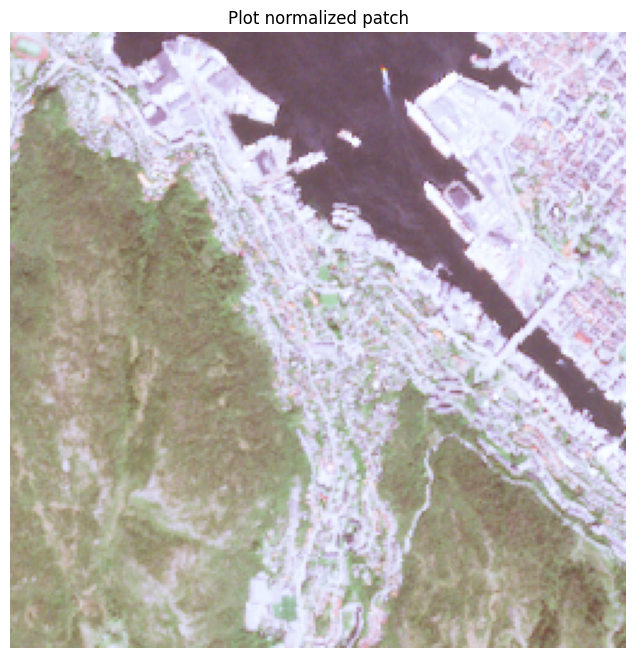

In [51]:
# Create RGB composite using NIR, SWIR, and Red

plt.figure(figsize=(8, 8))
plt.imshow(patches[120])
plt.title("Plot normalized patch")
plt.axis("off")
plt.show()

# Plot patch


In [31]:
cropped_img_rgb = cropped_img[[red_band, green_band, blue_band]].data

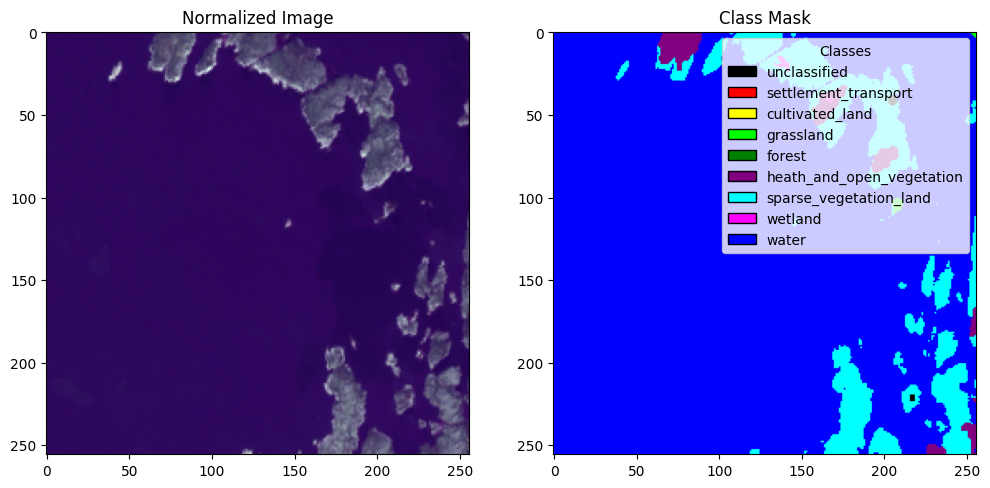

In [32]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(normalize_image(cropped_img_rgb).transpose(1, 2, 0))
axs[0].set_title("Normalized Image")

# Plot the mask
axs[1].imshow(cropped_mask.data.squeeze(), cmap=ListedColormap(class_colors))
axs[1].set_title("Class Mask")

axs[1].legend(handles=legend_elements, loc="upper right", title="Classes")
plt.show()

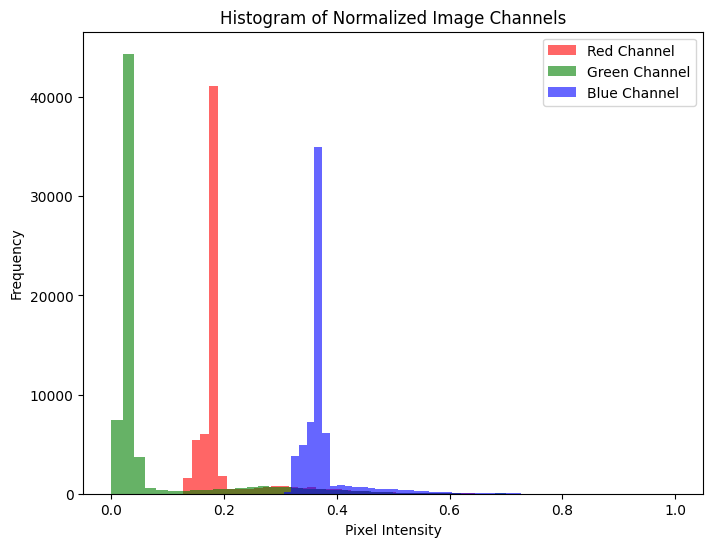

In [ ]:
import matplotlib.pyplot as plt

# Assuming norm_cropped shape is (3, H, W) for RGB channels
channels = ["Red", "Green", "Blue"]
colors = ["red", "green", "blue"]

plt.figure(figsize=(8, 6))
for i, (channel_name, color) in enumerate(zip(channels, colors, strict=False)):
    # Flatten the channel and plot the histogram
    plt.hist(
        normalize_image(cropped_img_rgb)[i].flatten(),
        bins=50,
        color=color,
        alpha=0.6,
        label=f"{channel_name} Channel",
    )

plt.title("Histogram of Normalized Image Channels")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()
